In [1]:
#import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, concatenate,Conv1D, MaxPooling1D,Flatten
from tensorflow.keras.models import Model,Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import time
from keras.preprocessing.image import ImageDataGenerator


C:\Users\lenovo\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#class inputs
base_path = r"C:\Users\lenovo\\DualChannelThesis\CWRU"

statistics_directories = [
    base_path + "\\stats\\bopolar7",
    base_path + "\\stats\\bopolar14",
    base_path + "\\stats\\bopolar21",
    base_path + "\\stats\\irpolar7",
    base_path + "\\stats\\irpolar14",
    base_path + "\\stats\\irpolar21",
    base_path + "\\stats\\orpolar7",
    base_path + "\\stats\\orpolar14",
    base_path + "\\stats\\orpolar21",
]

image_directories = [
    base_path + "\\spectogtam\\bopolar7",
    base_path + "\\spectogtam\\bopolar14",
    base_path + "\\spectogtam\\bopolar21",
    base_path + "\\spectogtam\\irpolar7",
    base_path + "\\spectogtam\\irpolar14",
    base_path + "\\spectogtam\\irpolar21",
    base_path + "\\spectogtam\\orpolar7",
    base_path + "\\spectogtam\\orpolar14",
    base_path + "\\spectogtam\\orpolar21",
]


In [3]:
def get_label(directory):
    if "bopolar" in directory:
        return 0  # bopolar
    elif "irpolar" in directory:
        return 1  # irpolar
    else:
        return 2  # orpolar


In [4]:
statistics_data = []
statistics_labels = []
for directory in statistics_directories:
    files = os.listdir(directory)
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            if not df.empty:
                features = df.values.flatten()
                statistics_data.append(features)
                statistics_labels.append(get_label(directory))

In [5]:
polar_images = []
polar_labels = []
for directory in image_directories:
    files = os.listdir(directory)
    for file in files:
        if file.endswith('.png'):
            file_path = os.path.join(directory, file)
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (64, 64))
            polar_images.append(img)
            polar_labels.append(get_label(directory))

In [6]:
polar_images = np.array(polar_images)
polar_labels = np.array(polar_labels)

statistics_data = np.array(statistics_data)
statistics_labels = np.array(statistics_labels)

In [7]:
#splitting
statistics_X_train, statistics_X_test, statistics_y_train, statistics_y_test = train_test_split(
    statistics_data, statistics_labels, test_size=0.2, random_state=42)

In [8]:
#scaling the numeric statistical input
scaler = StandardScaler()
statistics_X_train = scaler.fit_transform(statistics_X_train)
statistics_X_test = scaler.transform(statistics_X_test)

In [9]:
#splitting
polar_X_train, polar_X_test, polar_y_train, polar_y_test = train_test_split(
    polar_images, polar_labels, test_size=0.2, random_state=42)

In [10]:
#generate data as a data augmentation step

datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(polar_X_train)

In [11]:
#Generating class weight
class_counts = Counter(statistics_labels)
total_samples = len(statistics_labels)
class_weights = {class_index: total_samples / (class_count * len(class_counts)) for class_index, class_count in class_counts.items()}


In [12]:
#define inputs
statistics_input = Input(shape=(statistics_X_train.shape[1],1))
polar_input = Input(shape=(64, 64, 3))

In [13]:
#define statistic based 1D CNN model
def statistics_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape, padding="same"))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 2, activation='relu', padding="same"))  
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    return model


In [14]:
vgg16_base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(64, 64, 3),  
)

vgg16_output = Flatten()(vgg16_base_model(polar_input))

statistics_branch_model = statistics_model((statistics_X_train.shape[1], 1))
statistics_output = statistics_branch_model(statistics_input)

In [15]:
#concatanating the features from both channels

combined_input = concatenate([statistics_output, vgg16_output])
x = Dense(256, activation='relu')(combined_input)
x = Dropout(0.5)(x)
output = Dense((3), activation='softmax')(x)

In [16]:
model = Model(inputs=[statistics_input, polar_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
#model training
epochs_list = [20,30]
batch_sizes_list = [32,64]
results = []
best_accuracy = 0.0  # Initialize best_accuracy
best_time = 0.0
for epoch in epochs_list:
    for batch_size in batch_sizes_list:
        print(f"Training with {epoch} epochs and batch size {batch_size}")
        start_time = time.time()
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit([statistics_X_train, polar_X_train],
                            polar_y_train,
                            epochs=epoch,
                            batch_size=batch_size,
                            validation_split=0.2,
                            class_weight=class_weights)
        end_time = time.time()
        elapsed_time = end_time - start_time
        # Evaluation
        test_loss, test_accuracy = model.evaluate([statistics_X_test, polar_X_test], polar_y_test)
        predictions = model.predict([statistics_X_test, polar_X_test])
        predicted_labels = np.argmax(predictions, axis=1)

        accuracy = accuracy_score(statistics_y_test, predicted_labels)
        f1 = f1_score(statistics_y_test, predicted_labels, average='weighted')
        precision_vals = precision_score(statistics_y_test, predicted_labels, average=None)
        recall_vals = recall_score(statistics_y_test, predicted_labels, average=None)

        n_classes = 3  # Number of classes
        fpr = dict()
        tpr = dict()
        roc_auc_vals = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(statistics_y_test, predictions[:, i], pos_label=i)
            roc_auc_vals[i] = auc(fpr[i], tpr[i])

        results.append({
            'epochs': epoch,
            'batch_size': batch_size,
            'test_accuracy': test_accuracy,
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision_vals,
            'recall': recall_vals,
            'roc_auc': roc_auc_vals
        })
        test_loss, test_accuracy = model.evaluate([statistics_X_test, polar_X_test], polar_y_test)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_time = elapsed_time


Training with 20 epochs and batch size 32
Epoch 1/20
36/36 [==============================] - 69s 2s/step - loss: 4.7809 - accuracy: 0.4876 - val_loss: 0.7550 - val_accuracy: 0.7951
Epoch 2/20
36/36 [==============================] - 67s 2s/step - loss: 0.4574 - accuracy: 0.8558 - val_loss: 0.3552 - val_accuracy: 0.8304
Epoch 3/20
36/36 [==============================] - 66s 2s/step - loss: 0.2764 - accuracy: 0.8752 - val_loss: 0.2889 - val_accuracy: 0.8516
Epoch 4/20
36/36 [==============================] - 52s 1s/step - loss: 0.2304 - accuracy: 0.8805 - val_loss: 0.2505 - val_accuracy: 0.8551
Epoch 5/20
36/36 [==============================] - 42s 1s/step - loss: 0.2038 - accuracy: 0.8973 - val_loss: 0.2485 - val_accuracy: 0.8622
Epoch 6/20
36/36 [==============================] - 40s 1s/step - loss: 0.1977 - accuracy: 0.8867 - val_loss: 0.2509 - val_accuracy: 0.8975
Epoch 7/20
36/36 [==============================] - 43s 1s/step - loss: 0.2029 - accuracy: 0.8929 - val_loss: 0.2621 -

In [18]:
# print Validation, Accuracy, F1-Score

for result in results:
    print(f"Epochs: {result['epochs']}, Batch Size: {result['batch_size']}, Test Accuracy: {result['test_accuracy']}, F1-Score: {result['f1_score']}")
print(f"Time taken for best hyperparameters (with test accuracy {best_accuracy:.2f}): {best_time:.2f} seconds")


Epochs: 20, Batch Size: 32, Test Accuracy: 0.9576271176338196, F1-Score: 0.9574664152671386
Epochs: 20, Batch Size: 64, Test Accuracy: 0.9774011373519897, F1-Score: 0.9774011299435028
Epochs: 30, Batch Size: 32, Test Accuracy: 0.9774011373519897, F1-Score: 0.9773967884597573
Epochs: 30, Batch Size: 64, Test Accuracy: 0.9802259802818298, F1-Score: 0.9802244067543497
Time taken for best hyperparameters (with test accuracy 0.98): 1168.43 seconds


In [19]:
#best results
best_result_test = max(results, key=lambda x: x['test_accuracy'])
print("\nBest Hyperparameters (Test Accuracy):")
print("Epochs:", best_result_test['epochs'])
print("Batch Size:", best_result_test['batch_size'])
print("Test Accuracy:", best_result_test['test_accuracy'])


Best Hyperparameters (Test Accuracy):
Epochs: 30
Batch Size: 64
Test Accuracy: 0.9802259802818298


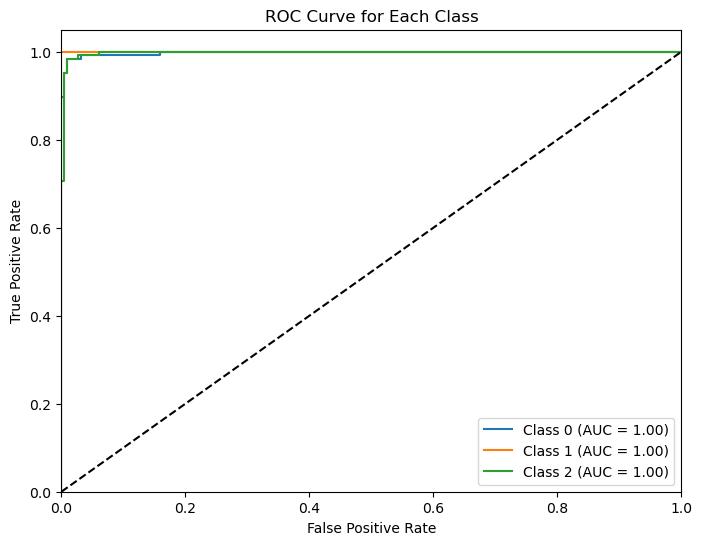

In [20]:
#plot roc curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(polar_y_test, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


In [21]:
precision = precision_score(polar_y_test, predicted_labels, average=None)
recall = recall_score(polar_y_test, predicted_labels, average=None)

print("\nPrecision for Each Class:", precision)
print("Recall for Each Class:", recall)



Precision for Each Class: [0.99180328 1.         0.953125  ]
Recall for Each Class: [0.95275591 1.         0.99186992]


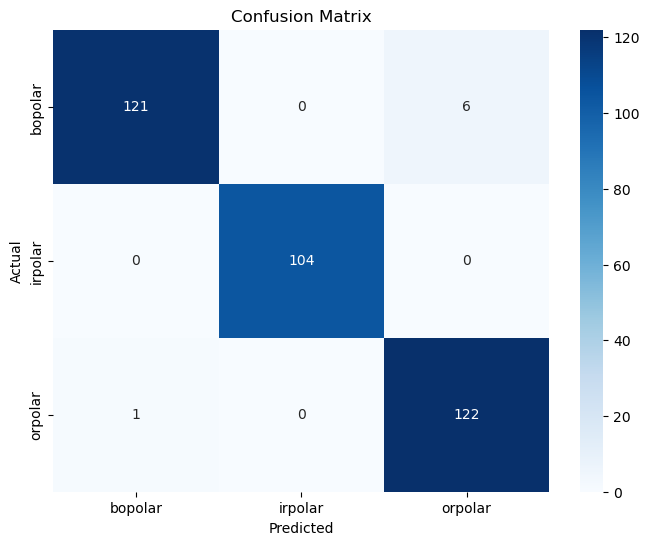

In [22]:
#plot roc curve
conf_matrix = confusion_matrix(polar_y_test, predicted_labels)
class_labels = ['bopolar', 'irpolar', 'orpolar']
confusion_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
